# Data Preparation

In [1]:
from __future__ import absolute_import
from numpy import asarray
from numpy import save
from mqt.predictor.driver import Predictor
from mqt.predictor import utils

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

training_data, names_list, scores_list = utils.load_training_data()
X, y = zip(*training_data)
X = list(X)
y = list(y)
for i in range(len(X)):
    X[i] = list(X[i])
    scores_list[i] = list(scores_list[i])


X, y, indices = np.array(X), np.array(y), np.array(range(len(y)))

non_zero_indices = []
for i in range(len(X[0])):
    if sum(X[:, i]) > 0:
        non_zero_indices.append(i)
X = X[:, non_zero_indices]
data = asarray(non_zero_indices)
save("non_zero_indices.npy", data)

(
    X_train,
    X_test,
    y_train,
    y_test,
    indices_train,
    indices_test,
) = train_test_split(X, y, indices, test_size=0.3, random_state=5)

scores_filtered = [scores_list[i] for i in indices_test]
names_filtered = [names_list[i] for i in indices_test]

predictor = Predictor()
performance = []

/Users/nils/Documents/repos/MQTPredictor/src/mqt/predictor ['training_data', 'calibration_files', '.DS_Store', 'non_zero_indices.npy', 'training_samples', 'trained_clf.joblib', '__init__.py', 'training_samples_compiled', '__pycache__', 'mqt_predictor.ipynb', 'results', 'utils.py', '.ipynb_checkpoints', 'driver.py']


# Random Forest

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: 'mqt/predictor/results/RandomForestClassifier.pdf'

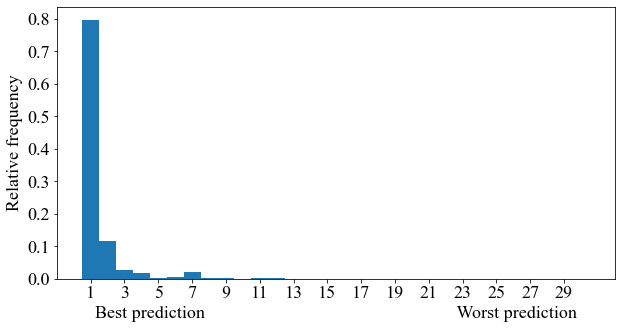

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(random_state=0)

tree_param = [
    {
        "n_estimators": [100, 200, 500],
        "max_features": ["auto", "sqrt"],
        "max_depth": list(range(8, 30, 6)),
        "min_samples_split": list(range(2, 20, 6)),
        "min_samples_leaf": list(range(2, 20, 6)),
        "bootstrap": [True, False],
    },
]

clf = GridSearchCV(clf, tree_param, cv=5, n_jobs=8).fit(X_train, y_train)


y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(
    scores_filtered, y_pred, y_test, filename="RandomForestClassifier"
)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Feature Importance: ", clf.best_estimator_.feature_importances_)
performance.append(("RandomForestClassifier", clf.best_score_, top3, max(res)))

predictor.set_classifier(clf.best_estimator_)
utils.save_classifier(clf.best_estimator_)

### Feature Importances

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

openqasm_qc_list = utils.get_openqasm_gates()
feature_names = [openqasm_qc_list[i] for i in range(0, len(openqasm_qc_list))]
feature_names.append("num_qubits")
feature_names.append("depth")
feature_names.append("program_communication")
feature_names.append("critical_depth")
feature_names.append("entanglement_ratio")
feature_names.append("parallelism")
feature_names.append("liveness")
feature_names = [feature_names[i] for i in non_zero_indices]

importances = clf.best_estimator_.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in clf.best_estimator_.estimators_], axis=0
)

idx = np.argsort(-importances)

plt.figure(figsize=(8, 8))
plt.bar(np.array(feature_names)[idx], np.array(importances)[idx])
plt.errorbar(
    np.array(feature_names)[idx],
    np.array(importances)[idx],
    np.array(std)[idx],
    fmt="o",
    color="lightgreen",
)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("Relative feature importance", fontsize=18)
plt.tight_layout()
plt.savefig("mqt/predictor/results/feature_importances.pdf")
plt.show()

In [ ]:
predictor.plot_eval_all_detailed_compact_normed(
    names_filtered, scores_filtered, y_pred, y_test
)

# GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()

param_grid = {
    "learning_rate": [0.01, 0.1, 1],
}

clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(
    scores_filtered, y_pred, y_test, filename="GradientBoostingClassifier"
)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("GradientBoostingClassifier", clf.best_score_, top3, max(res)))

# Current Decision Tree Classifier

In [ ]:
# predictor.train_decision_tree_classifier(X, y, names_list, scores_list);

In [ ]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

clf = tree.DecisionTreeClassifier(random_state=5)

tree_param = [
    {
        "criterion": ["entropy", "gini"],
        "max_depth": list(range(1, 15, 1)),
        "min_samples_split": list(range(2, 20, 4)),
        "min_samples_leaf": list(range(2, 20, 4)),
        "max_leaf_nodes": list(range(2, 200, 40)),
        "max_features": list(range(1, len(non_zero_indices), 10)),
    },
]
clf = GridSearchCV(clf, tree_param, cv=5, n_jobs=8).fit(X_train, y_train)
y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(
    scores_filtered, y_pred, y_test, filename="DecisionTreeClassifier"
)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Feature Importance: ", clf.best_estimator_.feature_importances_)
performance.append(("DecisionTreeClassifier", clf.best_score_, top3, max(res)))

# Nearest Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
param_grid = dict(n_neighbors=range(1, 10, 1))
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(
    scores_filtered, y_pred, y_test, filename="KNeighborsClassifier"
)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print(("Top 3: ", top3))
performance.append(("KNeighborsClassifier", clf.best_score_, top3, max(res)))

# SVM

In [ ]:
from sklearn import svm

clf = svm.SVC()
param_grid = {"C": [0.1, 1, 10], "gamma": [1, 0.1, 0.01], "kernel": ["rbf", "sigmoid"]}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test, filename="SVM")

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("SVM", clf.best_score_, top3, max(res)))

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
param_grid = {"var_smoothing": np.logspace(0, -9, num=100)}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(
    scores_filtered, y_pred, y_test, filename="GaussianNB"
)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("GaussianNB", clf.best_score_, top3, max(res)))

# SGD

In [ ]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=200)

param_grid = {
    "average": [True, False],
    "l1_ratio": np.linspace(0, 1, num=10),
    "alpha": np.power(10, np.arange(-2, 1, dtype=float)),
}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(
    scores_filtered, y_pred, y_test, filename="SGDClassifier"
)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("SGDClassifier", clf.best_score_, top3, max(res)))

# Save Performance Results

In [ ]:
print(performance)

filename = "mqt/predictor/results/performances.csv"
with open(filename, "w") as f:
    f.write("Algorithm, Accuracy, Top3, Worst Rank\n")
    for sublist in performance:
        line = "{}, {}, {}, {} \n".format(
            sublist[0], sublist[1], sublist[2], sublist[3]
        )
        f.write(line)

# Debugging

In [ ]:
from setuptools import find_namespace_packages, setup

In [ ]:
find_namespace_packages(include=["src.mqt.*"])